<a href="https://colab.research.google.com/github/valencorrea/7506R-2C2022-GRUPO14/blob/reentrega/7506R_TP2_GRUPO14_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

______________________________________
# <center>**Trabajo Practico Nº2 para la Materia *Organización de Datos***</center>

*Integrantes*:
- 103963	Carolina Di Matteo	cdimatteo@fi.uba.ar
- 101231	Pablo Salvador Dimartino	pdimartino@fi.uba.ar
- 100113	Juan Sebastian Burgos	jsburgos@fi.uba.ar
- 104415	Valentina Laura Correa	vcorrea@fi.uba.ar

*Grupo*: 14

*Repositorio*: [github](https://github.com/valencorrea/7506R-2C2022-GRUPO14)

*Curso*: Rodriguez

*Cuatrimestre*: 2c2022

Datos provistos por [properati](https://www.properati.com.ar).
______________________________________


## Introducción

El presente trabajo práctico es una continuación del ‘TP1: Propiedades en Venta’. 

En la entrega anterior se propuso aplicar técnicas de análisis exploratorio, preprocesamiento de datos, agrupamiento, clasificación y regresión. Siguiendo esta línea, y con el objetivo de continuar resolviendo problemas reales de ciencia de datos, en esta segunda parte se implementarán nuevos modelos predictivos a partir de los anteriormente mencionados. 

En esta oportunidad se buscará demostrar los conocimientos adquiridos sobre procesamiento del lenguaje natural, redes neuronales y ensamble de modelos. Para esto se utilizarán tanto datasets provistos por la materia, tomados de la página de la empresa Properati, como los generados por el grupo en el trabajo anterior.

## 0. Setup

### Importación de bibliotecas

In [81]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [82]:
pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [83]:
pip install types-all

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Funciones auxiliares

In [84]:
def metricas_clasificacion(y_test, y_pred):
    print(f'Accuracy: {round(accuracy_score(y_test, y_pred),2)}')
    print(f'Precision: {round(precision_score(y_test, y_pred, average="macro"),2)}')
    print(f'Recall: {round(recall_score(y_test, y_pred, average="macro"),2)}')
    print(f'F1 Score: {round(f1_score(y_test, y_pred, average="macro"),2)}')

In [85]:
def prediccion_y_metricas_regresion(regressor, x_test, y_test):
  
  y_pred = regressor.predict(x_test)

  pct = np.sum(y_test.values == y_pred) / len(y_test) * 100

  print(f"Se obtuvo un {round(pct,3)}% de aciertos.")

  mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

  print(f"El error según la métrica 'Mean Square Error' de test es: {mse}")

  rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

  print(f"El error según la métrica 'Root Mean Square Error' de test es: {rmse}")

  print(f"El coeficiente de determinación de test es: {regressor.score(x_test, y_test)}")
  
  return y_pred

In [86]:
#Importación de librerías

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from xgboost import XGBRegressor
from xgboost import plot_importance
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from collections import Counter
import unidecode
import re
from joblib import load, dump
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from keras.metrics import MeanSquaredError
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score, r2_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from collections import defaultdict

#Configuración de Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#Ejecución con Drive
if 'google.colab' in str(get_ipython()):
    IN_COLAB = True
else:
    IN_COLAB = False

if IN_COLAB :
    from google.colab import drive
    drive.mount('/content/drive')

    df_train = pd.read_csv('/content/drive/MyDrive/📒 Organización de Datos (75.06)/TPS/TP2/DATASETS/df_train_tp1.csv')
    df_test = pd.read_csv('/content/drive/MyDrive/📒 Organización de Datos (75.06)/TPS/TP2/DATASETS/df_test_tp1.csv')
    properati_descrip = pd.read_csv('/content/drive/MyDrive/📒 Organización de Datos (75.06)/TPS/TP1/properati_argentina_2021_decrip.csv')
    stop_words = '/content/drive/MyDrive/📒 Organización de Datos (75.06)/TPS/TP2/stopwords.txt'
else:
    df_train = pd.read_csv('./DATASETS/df_train_tp1.csv')
    df_test = pd.read_csv('./DATASETS/df_test_tp1.csv')
    properati_descrip = pd.read_csv('properati_argentina_2021_decrip.csv')
    stop_words = 'stopwords'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Funciones auxiliares

In [87]:
def metricas_clasificacion(y_test, y_pred):
    print(f'Accuracy: {round(accuracy_score(y_test, y_pred),2)}')
    print(f'Precision: {round(precision_score(y_test, y_pred, average="macro"),2)}')
    print(f'Recall: {round(recall_score(y_test, y_pred, average="macro"),2)}')
    print(f'F1 Score: {round(f1_score(y_test, y_pred, average="macro"),2)}')

In [88]:
def prediccion_y_metricas_regresion(regressor, x_test, y_test):

  y_pred = regressor.predict(x_test)

  print(f"Se obtuvo un Score de {round(regressor.score(x_test, y_test)*100,3)}%")

  mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

  print(f"El error según la métrica 'Mean Square Error' de test es: {mse}")

  rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

  print(f"El error según la métrica 'Root Mean Square Error' de test es: {rmse}")

  return

In [89]:
def format_aspects(line, word):
    format = r"\W*([\w]+)"
    n = 2
    x = re.search(r'{}\W*{}{}'.format(format*n, word, format*n), line)
    if x is not None:
        return x.group()
    else:
        return ""

In [90]:
def convert_b_m_a(x):
    mx = max(x[0], x[1], x[2])
    if mx == x[0]:
        return 'bajo'
    elif mx == x[1]:
        return 'medio'
    elif mx == x[2]:
        return 'alto'

In [91]:
def estandarizar(df, columns):
  sscaler = StandardScaler()

  for col in columns:
    df[col] = sscaler.fit_transform(pd.DataFrame(df[col]))

In [92]:
def limpiar_values_de_aspects(df, aspects, values):
    i = 0
    for aspect in aspects:
        for word in values[i]:
            df[aspect] = df[aspect].apply(lambda line: word if word in line else line)
        df[aspect] = df[aspect].apply(lambda line: line if len(line.split())<2 else '')
        i = i+1

In [93]:
def evaluate_model(model, x, y, splits, n):
    cv = RepeatedStratifiedKFold(n_splits=splits, n_repeats=n, random_state=1)
    scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

In [94]:
import plotly.graph_objects as go

def plot_results(model_scores, name):
    
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )
    
    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Error Cuadrático Medio',
    showlegend=False)
    fig.show()

### Preparación de datasets

In [95]:
df_train_x = df_train.drop(["property_price", "tipo_precio_3"], axis="columns")
df_train_y_regresion = df_train["property_price"]
df_train_y_clasificacion = df_train["tipo_precio_3"]

df_test_x = df_test.drop(["property_price", "tipo_precio_3"], axis="columns")
df_test_y_regresion = df_test["property_price"]
df_test_y_clasificacion = df_test["tipo_precio_3"]

## 1. Procesamiento del Lenguaje Natural

### 1. a) Ampliación del dataset
___

Hagamos un merge del dataset original y el de descripciones, y quedémonos únicamente con las columnas `id` y `property_description`:

In [ ]:
df_descrip = pd.merge(df_train_x, properati_descrip, on="id")
df_descrip = df_descrip[["id", "property_description"]]

df_test_descrip = pd.merge(df_test_x, properati_descrip, on="id")
df_test_descrip = df_test_descrip[["id", "property_description"]]

In [ ]:
df_test_descrip

,id,property_description
0,ahcEMvB66wjPz0SYWZQDBw==,Corredor Responsable: Juan Carlos Treco - CUCI...
1,M0g0l0s6S13X+cZlGkUo8g==,Corredor Responsable: Micaela Perez / Lucas Fe...
2,V/KMMLRRx/Nn+g3m5lrW7A==,Corredor Responsable: Gustavo Guastello - C.U....
3,odR0QjYc3xtaYfqNJvbOSQ==,PH A ESTRENAR SANCHEZ DE LORIA AL 1500 Y CONST...
4,RqOcPIKYYZDG+CFMq2c1RA==,EXCELENTE SEMIPISO 3 AMB C/BALCON LUMINOSO EN ...
...,...,...
18600,g2fBcuyxiq3V0GdPATLFDw==,Venta DEPARTAMENTO 2 Ambientes Villa Ortuzar. ...
18601,2jfcV70r5M8iASKFbpFEqA==,"Departamento a estrenar monoambiente, luminoso..."
18602,H4X7bNq04pK7U6fCcbxYNg==,Corredor Responsable: Daniel Acosta - CUCICBA ...
18603,QWBP5Zp0TBUlFrzP9GO9bA==,El departamento se ubica en la PB y contiene:<...


Busquemos aspectos de una propiedad utilizando la columna `property_description`.

Veamos cuántos registros nulos existen:

In [ ]:
print(f"Hay {df_descrip['property_description'].isna().sum()} datos nulos.")

Hay 0 datos nulos.


Veamos cuáles son las 100 palabras más comunes en el campo de descripción de propiedades:

In [ ]:
Counter(" ".join(df_descrip["property_description"]).split()).most_common(100)

[('de', 857976),
 ('y', 507778),
 ('con', 401867),
 ('la', 290195),
 ('en', 278176),
 ('a', 243751),
 ('el', 169952),
 ('del', 153279),
 ('que', 140055),
 ('por', 133635),
 ('al', 125215),
 ('-', 113875),
 ('un', 103716),
 ('las', 90713),
 ('los', 88435),
 ('para', 88190),
 ('se', 63109),
 ('DE', 56457),
 ('son', 56420),
 ('2', 52790),
 ('es', 50384),
 ('una', 48927),
 ('3', 41258),
 ('cocina', 38889),
 ('ambientes', 38848),
 ('valor', 38420),
 ('esta', 38292),
 ('muy', 36893),
 ('x', 36800),
 ('Av.', 36630),
 ('comedor', 35535),
 ('baño', 35476),
 ('Y', 34141),
 ('CON', 33915),
 ('no', 33912),
 ('piso', 33348),
 ('o', 33050),
 ('/', 32253),
 ('tu', 32101),
 ('A', 32063),
 ('hasta', 30269),
 ('balcón', 29805),
 ('inmueble', 28725),
 ('casa', 28655),
 ('No', 28635),
 ('propiedad.', 28070),
 ('30%', 27684),
 ('departamento', 27670),
 ('EN', 27267),
 ('cuadras', 27069),
 ('Corredor', 26991),
 ('préstamo', 26920),
 ('cuota', 26780),
 ('medidas', 26422),
 ('Responsable:', 25970),
 ('living'

Podemos observar que podríamos optimizar el texto mediante algunas técnicas de reducción y/o transformación. Entre otras:

Eliminemos la etiqueta `<br>` de html:

In [ ]:
df_descrip["property_description"] = df_descrip["property_description"].apply(lambda line: line.replace("<br>", " "))
df_test_descrip["property_description"] = df_test_descrip["property_description"].apply(lambda line: line.replace("<br>", " "))

Transformemos todas las palabras a minúsculas, de modo que el contador no realice distinciones:

In [ ]:
df_descrip["property_description"] = df_descrip["property_description"].apply(lambda line: line.lower())
df_test_descrip["property_description"] = df_test_descrip["property_description"].apply(lambda line: line.lower())


Quitemos los tíldes de las letras:

In [ ]:
df_descrip["property_description"] = df_descrip["property_description"].apply(lambda line: unidecode.unidecode(line))
df_test_descrip["property_description"] = df_test_descrip["property_description"].apply(lambda line: unidecode.unidecode(line))

Eliminemos los símbolos:

In [ ]:
df_descrip["property_description"] = df_descrip["property_description"].apply(lambda line: re.sub(r'[^\w]', ' ', line))
df_test_descrip["property_description"] = df_test_descrip["property_description"].apply(lambda line: re.sub(r'[^\w]', ' ', line))

Eliminemos los espacios múltiples entre palabras:

In [ ]:
df_descrip["property_description"] = df_descrip["property_description"].apply(lambda line: re.sub("\s\s+" , " ", line))
df_test_descrip["property_description"] = df_test_descrip["property_description"].apply(lambda line: re.sub("\s\s+" , " ", line))

Utilizando el contenido del archivo `stop_words.txt`, eliminemos palabras sin significado del datset y colocamos los cambios en uno nuevo:

In [ ]:
with open(stop_words) as f:
    lines = f.read().splitlines()

f = lambda x: ' '.join([item for item in x.split() if item not in lines])

df_descrip["property_description"] = df_descrip["property_description"].apply(f)
df_test_descrip["property_description"] = df_test_descrip["property_description"].apply(f)

Luego de estas transformaciones, veamos cuáles son las palabras más utilizadas:

In [ ]:
Counter(" ".join(df_descrip["property_description"]).split()).most_common(100)

Seleccionemos los aspectos que nos parecen relevantes, para luego buscar sus posibles valores.

Para esto, elegimos: `cocina`, `pisos`, `calefaccion`, `expensas`, `lavadero`, `balcon`, `cochera` y `aire` y limpiamos cualquier tipo de formato restante en el dataset:

In [ ]:
aspectos = ['cocina', 'pisos', 'calefaccion', 'expensas', 'lavadero', 'balcon', 'cochera', 'aire']

In [ ]:
for word in aspectos:
    df_descrip[word] = df_descrip["property_description"].apply(lambda line: format_aspects(line, word))
    df_test_descrip[word] = df_test_descrip["property_description"].apply(lambda line: format_aspects(line, word))

Veamos cuáles son las 15 palabras más comunes para cada uno de los aspectos elegidos:

In [ ]:
cant_val_aspectos = 15

#### Aspecto `cocina`




In [ ]:
Counter(" ".join(df_descrip["cocina"]).split()).most_common(cant_val_aspectos)

Para `cocina`, los valores podrían ser: 
- integrada
- lavadero
- completa

#### Aspecto `pisos`

In [ ]:
Counter(" ".join(df_descrip["pisos"]).split()).most_common(cant_val_aspectos)

Para `pisos`, los valores podrían ser: 
- porcelanato
- parquet
- madera

#### Aspecto `calefaccion`

In [ ]:
Counter(" ".join(df_descrip["calefaccion"]).split()).most_common(cant_val_aspectos)

Para `calefaccion`, los valores podrían ser: 
- radiadores
- radiante
- central
- individual

#### Aspecto `expensas`

In [ ]:
Counter(" ".join(df_descrip["expensas"]).split()).most_common(cant_val_aspectos*2)

Para `expensas`, los valores podrían ser: 
- servicios
- impuestos 
- bajas

#### Aspecto `lavadero`

In [ ]:
Counter(" ".join(df_descrip["lavadero"]).split()).most_common(cant_val_aspectos)

Para `lavadero`, los valores podrían ser: 
- independiente
- cocina
- comedor

#### Aspecto `balcon`

In [ ]:
Counter(" ".join(df_descrip["balcon"]).split()).most_common(cant_val_aspectos)

Para `balcon`, los valores podrían ser: 
- frente
- amplio 
- terraza 
- salida 
- corrido
- luminoso

#### Aspecto `cochera`

In [ ]:
Counter(" ".join(df_descrip["cochera"]).split()).most_common(cant_val_aspectos*2)

Para `cochera`, los valores podrían ser: 
- fija
- cubierta

#### Aspecto `aire`

In [ ]:
Counter(" ".join(df_descrip["aire"]).split()).most_common(cant_val_aspectos)

Para `aire`, posibles valores son: 
- split 
- central 
- acondicionado

#### Consolidación de valores

A continuación creamos la variable `values`, que contiene los posibles valores para cada uno de los aspectos elegidos:

In [ ]:
values_cocina = ['integrada' , 'lavadero' , 'completa']
values_pisos = ['porcelanato' , 'parquet' , 'madera']
values_calefaccion = ['radiadores' , 'radiante' , 'central' , 'individual']
values_expensas = ['serviocios' , 'impuestos' , 'bajas']
values_lavadero = ['independiente' , 'cocina' , 'comedor']
values_balcon = ['frente' , 'amplio' , 'terraza' , 'salida' , 'corrido' , 'luminoso']
values_cochera = ['fija' , 'cubierta']
values_aire = ['split' , 'central' , 'acondicionado']

In [ ]:
values = [values_cocina, values_pisos, values_calefaccion, values_expensas, values_lavadero, values_balcon, values_cochera, values_aire]

En primer lugar, creamos un dataset auxiliar que tenga los IDs y las columnas de los aspectos:

In [ ]:
aux_df = df_descrip.copy()
aux_df_test = df_test_descrip.copy()

aux_df.drop('property_description', inplace=True, axis=1)
aux_df_test.drop('property_description', inplace=True, axis=1)

Luego creamos una función a la que -pasándole un dataset, los aspectos y el listado de valores posibles- reemplace el contenido de las columnas por los valores correspondientes.

Modificamos las columnas de los aspectos, para que sólo queden los valores correspondientes:

In [ ]:
limpiar_values_de_aspects(aux_df, aspectos, values)
limpiar_values_de_aspects(aux_df_test, aspectos, values)
aux_df.head(20)

Por último hacemos el merge con el dataset original, teniendo en cuenta los IDs:

In [ ]:
df = df_train_x.copy()
df = pd.merge(df,aux_df, on="id")
df.drop("id", inplace=True, axis="columns")

df_test = df_test_x.copy()
df_test = pd.merge(df_test,aux_df_test, on="id")
df_test.drop("id", inplace=True, axis="columns")

df.head(20)

#### Exportación de Datos

Exportamos los datasets generados:

In [ ]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📒 Organización de Datos (75.06)/TPS/TP2/DATASETS/1a_df_descrip.csv'
else:
  path = 'DATASETS/1a_df_descrip.csv'

df_descrip.to_csv(path)

In [ ]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📒 Organización de Datos (75.06)/TPS/TP2/DATASETS/1a_df_ampliado.csv'
else:
  path = 'DATASETS/1a_df_ampliado.csv'

df.to_csv(path)

### 1. b) Modelos
___

#### Sin optimización de hiperparámetros

Entrenemos un modelo de XGBoost con los mismos hiperparámetros utilizados en el TP1.

Realizamos One Hot Encoding para las nuevas variables cualitativas:

In [ ]:
df_dummies = pd.get_dummies(df, columns=['cocina', 'pisos', 'lavadero', 'calefaccion', 'expensas', 'balcon', 'cochera', 'aire'], drop_first=True)
df_test_dummies = pd.get_dummies(df_test, columns=['cocina', 'pisos', 'lavadero', 'calefaccion', 'expensas', 'balcon', 'cochera', 'aire'], drop_first=True)
df_dummies.head(5)

In [ ]:
df_dummies

Entrenamos el modelo:

In [ ]:
df_test_dummies

In [ ]:
XGB_Regressor = XGBRegressor(min_child_weight = 5, max_depth = 6, learning_rate = 0.3, gamma = 0.1, colsample_bytree = 0.3)
XGB_Regressor.fit(df_dummies, df_train_y_regresion)

Hagamos las predicciones y veamos cómo resultaron las métricas del modelo:

In [ ]:
prediccion_y_metricas_regresion(XGB_Regressor,df_test_dummies, df_test_y_regresion)

##### Importancia de features

Graficamos los 15 features más importantes para el modelo con los hiperparámetros del TP1

In [ ]:
sorted_idx = XGB_Regressor.feature_importances_.argsort()
sorted_idx = sorted_idx[-15:]
plt.barh(df_test_dummies.columns[sorted_idx], XGB_Regressor.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

Podemos observar que el feature más importante es la ubicación en Puerto Madero, seguido de cantidad de habitaciones y ubicación en Palermo Chico.

#### Con optimización de hiperparámetros

Veamos cómo se comporta el score con la optimización de hiperparámetros:

In [ ]:
params_grid = {'learning_rate': [0.20, 0.25, 0.30],
               'max_depth': [4, 5, 6, 8, 10],
               'min_child_weight': [1, 3, 5, 7, 9],
               'gamma': [0.1, 0.2 , 0.3, 0.4, 0.5],
               'colsample_bytree' : [0.3, 0.4, 0.5, 0.7, 0.8]}

randomCV = RandomizedSearchCV(estimator = XGBRegressor(),
                              param_distributions = params_grid,
                              scoring = make_scorer(r2_score),
                              cv = StratifiedKFold(n_splits = 5),
                              n_iter = 5)

randomCV.fit(df_dummies, df_train_y_regresion)

In [ ]:
randomCV.best_params_

In [ ]:
prediccion_y_metricas_regresion(randomCV.best_estimator_,df_test_dummies, df_test_y_regresion)

Observamos que, si bien las métricas mejoraron, las diferencias al optimizar los parámetros no fueron muy significativas.

##### Importancia de features

Graficamos los 15 features más importantes para el modelo con los hiperparámetros optimizados

In [ ]:
sorted_idx = randomCV.best_estimator_.feature_importances_.argsort()
sorted_idx = sorted_idx[-15:]
plt.barh(df_test_dummies.columns[sorted_idx], randomCV.best_estimator_.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

Podemos ver que la ubicación en Puerto Madero tiene aún más peso que en el modelo anterior y también como algunos de los features con los que expandimos el dataset (calefaccion_radiante y cochera_fija) toman más protagonismo, al igual que la superficie total.

#### Exportación del Modelo

Finalmente exportamos el modelo utilizado para predecir, resultante de la optimización de hiperparámetros:

In [ ]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📒 Organización de Datos (75.06)/TPS/TP2/MODELOS/XGB_Regressor.json'
else:
  path = './MODELOS/XGB_Regressor.json'

randomCV.best_estimator_.save_model(path)

## 2. Redes Neuronales

### 2. a) Regresión
___

#### Preparación del dataset

In [96]:
x_train_regresion = df_train_x.drop(["id"], axis=1).copy()
y_train_regresion = df_train_y_regresion.copy()
x_test_regresion = df_test_x.drop(["id"], axis=1).copy()
y_test_regresion = df_test_y_regresion.copy()

Normalizamos las entradas con StandardScaler:

In [97]:
estandarizar(x_train_regresion, ['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total'])
estandarizar(x_test_regresion, ['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total'])

In [98]:
x_train_regresion.head(5)

,start_date,end_date,latitud,longitud,property_rooms,property_surface_total,place_l4_Agronomía,place_l4_Almagro,place_l4_Balvanera,place_l4_Barracas,...,place_l4_Villa Ortuzar,place_l4_Villa Pueyrredón,place_l4_Villa Real,place_l4_Villa Riachuelo,place_l4_Villa Santa Rita,place_l4_Villa Soldati,place_l4_Villa Urquiza,place_l4_Villa del Parque,property_type_Departamento,property_type_PH
0,-0.013962,-0.503294,0.719583,0.842780,3.378343,5.038170,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,-1.018754,-1.315343,-0.536796,2.035631,0.985222,1.655539,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-0.941462,0.196521,0.993212,0.197907,0.985222,2.665736,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1.541533,0.757694,0.613858,0.854585,0.187515,0.522893,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,-0.941462,0.196521,0.993212,0.197907,0.985222,1.211664,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Búsqueda del mejor modelo

Creo una función que me permite generar un modelo a partir de sus hiperparámetros. Esta función tiene como parámetros la cantidad de nodos de la primera y anteúltima capa, la cantidad de capas ocultas, la función de activación y el optimizador. Todos los modelos que genera a excepción de los casos sin capas ocultas) tienen forma de 'pirámide'.

In [ ]:
import math
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras import Sequential
from keras.layers import Dense

cantidad_de_columnas = x_train_regresion.shape[1]

def crear_modelo(hidden_layers, first_layer_nodes, last_layer_nodes, activation_func, optimizer):

    sequential = Sequential()
    sequential.add(keras.layers.Dense(cantidad_de_columnas, input_shape=(cantidad_de_columnas,), activation=activation_func))

    if hidden_layers is 0 or hidden_layers is 1:
        decremento = 0
    else:
        decremento = math.ceil((first_layer_nodes - last_layer_nodes) / (hidden_layers - 1))

    for i in range (0, hidden_layers):
        nodos = first_layer_nodes - decremento * i
        sequential.add(Dense(nodos, activation=activation_func))

    sequential.add(Dense(1, activation=activation_func))

    sequential.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mse', 'mean_absolute_percentage_error']
    )

    return sequential


modelo =  KerasRegressor(build_fn=crear_modelo, verbose = False)

Luego busco el mejor modelo a partir de una grilla de parámetros arbitrarios con el método de 'GridSearchCV'. El criterio de mejor modelo es el que tenga menor error cuadrado, o lo que es equivalente, mayor error cuadrado negado. Nos limitamos en la cantidad de folds en el CV por el consumo temporal.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(
    hidden_layers=[1, 2],
    first_layer_nodes = [math.ceil(cantidad_de_columnas * 0.7), math.ceil(cantidad_de_columnas * 0.5)],
    last_layer_nodes = [5, cantidad_de_columnas * 0.5],
    activation_func = ['sigmoid', 'relu', 'tanh'],
    batch_size = [100],
    epochs = [60],
    optimizer=['RMSprop', 'adam']
)

grid = GridSearchCV(
    estimator = modelo,
    param_grid = param_grid,
    n_jobs=-1, cv=3,
    error_score='raise',
    scoring='neg_mean_squared_error'
)

Entrenamos todos los modelos

In [ ]:
grid_result = grid.fit(x_train_regresion, y_train_regresion)

Los parámetros y métricas del mejor modelo fueron:

In [ ]:
print("El error absoluto porcentual promedio del mejor modelo fue de: ", grid_result.best_estimator_.model.metrics[2].result().numpy())
print("El error absoluto cuadrado promedio del mejor modelo fue de: ", grid_result.best_estimator_.model.metrics[1].result().numpy())
print("Los parámetros óptimizados fueron: ", grid.best_params_)

In [ ]:
# print("Cross validation best model score: ", grid.best_score_) # Da un resultado negativo porque mientras mayor el valor absoluto, peor el modelo.
# print("Cross validation best model parameters: ", grid.best_params_)

#### Predicción

In [ ]:
grid_predict = grid.best_estimator_.model.evaluate(x_test_regresion, y_test_regresion)

#### Métricas

In [ ]:
print("El error absoluto porcentual promedio fue de: ", grid_predict[2])
print("El error absoluto cuadrado promedio fue de: ", grid_predict[1])

Veamos cómo se comporta la función de pérdida del mejor modelo según la cantidad de épocas utilizadas:

In [ ]:
epochs = range(60)
historia = grid_result.best_estimator_.model.history.history
plt.plot(epochs, historia['mean_absolute_percentage_error'], color='orange', label='MSE')
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.title('Error cuadrático medio por cantidad de épocas')
plt.legend()

#### Exportación de Datos

Finalmente, exportamos el modelo utilizado:

In [ ]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP2/MODELOS/Redes_Regressor.joblib'
else:
  path = './MODELOS/Redes_Regressor.joblib'

dump(modelo, path)

### 2. b) Clasificación
___


#### Preparación del dataset

In [99]:
x_train_clasificacion = df_train_x.drop(["id"], axis=1).copy()
y_train_clasificacion = df_train_y_clasificacion.copy()
x_test_clasificacion = df_test_x.drop(["id"], axis=1).copy()
y_test_clasificacion = df_test_y_clasificacion.copy()

In [100]:
x_train_clasificacion

,start_date,end_date,latitud,longitud,property_rooms,property_surface_total,place_l4_Agronomía,place_l4_Almagro,place_l4_Balvanera,place_l4_Barracas,...,place_l4_Villa Ortuzar,place_l4_Villa Pueyrredón,place_l4_Villa Real,place_l4_Villa Riachuelo,place_l4_Villa Santa Rita,place_l4_Villa Soldati,place_l4_Villa Urquiza,place_l4_Villa del Parque,property_type_Departamento,property_type_PH
0,737971,737991,-34.576973,-58.406591,7.0,415.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,737867,737868,-34.610046,-58.361382,4.0,194.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,737875,738097,-34.569770,-58.431032,4.0,260.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,738132,738182,-34.579756,-58.406144,3.0,120.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,737875,738097,-34.569770,-58.431032,4.0,165.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74246,737802,737946,-34.572157,-58.494807,3.0,1.0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
74247,737797,737946,-34.583718,-58.484141,4.0,1.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
74248,737802,737946,-34.572512,-58.478717,5.0,1.0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
74249,737802,737946,-34.572512,-58.478717,5.0,1.0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


Normalizamos mediante Z-Score:

In [101]:
x_train_clasificacion[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']] = zscore(x_train_clasificacion[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']], axis=1)

x_test_clasificacion[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']] = zscore(x_test_clasificacion[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']], axis=1)

Aplicamos One Hot encoding a la columna target de entrenamiento y test, para que tenga 3 columnas al igual que la salida del modelo:

In [102]:
y_train_clasificacion = pd.get_dummies(y_train_clasificacion, columns=['tipo_precio_3'], drop_first=False)
y_test_clasificacion = pd.get_dummies(y_test_clasificacion, columns=['tipo_precio_3'], drop_first=False)

#### Búsqueda del mejor modelo

Creo una función que me permite generar un modelo a partir de sus hiperparámetros. Esta función tiene como parámetros la cantidad de nodos de la primera y anteúltima capa, la cantidad de capas ocultas, la función de activación y el optimizador. Todos los modelos que genera a excepción de los casos sin capas ocultas) tienen forma de 'pirámide'.

In [ ]:
cantidad_de_columnas = x_train_clasificacion.shape[1]

def crear_modelo(hidden_layers, first_layer_nodes, last_layer_nodes, activation_func, optimizer):

    sequential = Sequential()
    sequential.add(keras.layers.Dense(first_layer_nodes, input_shape=(cantidad_de_columnas,)))

    if hidden_layers is 0 or hidden_layers is 1:
        decremento = 0
    else:
        decremento = math.ceil((first_layer_nodes - last_layer_nodes) / (hidden_layers - 1))

    for i in range (0, hidden_layers):
        nodos = first_layer_nodes - decremento * i
        sequential.add(Dense(nodos, activation=activation_func))

    sequential.add(Dense(3, activation=activation_func))

    sequential.compile(
        optimizer=optimizer,
        loss=None,
        # metrics=['accuracy'],
        metrics=['AUC', 'accuracy', 'Recall', 'Precision']
    )

    return sequential


modelo =  KerasClassifier(build_fn=crear_modelo, verbose = False)
# crear_modelo(0, 50, 5, 'softmax', 'adam').summary()

Luego busco el mejor modelo a partir de una grilla de parámetros arbitrarios con el método de 'GridSearchCV'. Nos limitamos en la cantidad de folds en el CV por el consumo temporal.

In [ ]:
from sklearn.model_selection import GridSearchCV

# param_grid = dict(
#     hidden_layers=[1, 2],
#     first_layer_nodes = [math.ceil(cantidad_de_columnas * 0.7), math.ceil(cantidad_de_columnas * 0.5)],
#     last_layer_nodes = [5, cantidad_de_columnas * 0.5],
#     activation_func = ['softmax'],
#     batch_size = [100],
#     epochs = [60],
#     optimizer=['adam']
# )

param_grid = dict(
    hidden_layers=[0],
    first_layer_nodes = [50],
    last_layer_nodes = [5],
    activation_func = ['softmax'],
    batch_size = [100],
    epochs = [60],
    optimizer=['adam']
)

grid = GridSearchCV(
    estimator = modelo,
    param_grid = param_grid,
    n_jobs=-1, cv=3,
    error_score='raise',
    scoring='accuracy'
)

Entrenamos todos los modelos

In [ ]:
# y_train_clasificacion = y_train_clasificacion.map({'bajo': 0, 'medio': 1, 'alto': 2})
grid_result = grid.fit(x_train_clasificacion, y_train_clasificacion)
# y_train_clasificacion

In [ ]:
# print("El error absoluto porcentual promedio del mejor modelo fue de: ", grid_result.best_estimator_.model.metrics[2].result().numpy())
# print("El error absoluto cuadrado promedio del mejor modelo fue de: ", grid_result.best_estimator_.model.metrics[1].result().numpy())
# print("Los parámetros óptimizados fueron: ", grid.best_params_)
# print("El score del mejor modelo fue: ", grid.best_score_)
print(grid_result.best_estimator_.model.metrics[2].name)
print(grid_result.best_estimator_.model.metrics[2].result().numpy())

In [ ]:
result = grid.best_estimator_.model.predict(x_test_clasificacion)

In [ ]:
# grid.best_estimator_.model.summary()
# result
# grid.predict(x_test_clasificacion)
result

In [ ]:
grid.predict(x_test_clasificacion)

In [ ]:
grid_result

In [ ]:
y_train_clasificacion

In [ ]:
d_in = x_train_clasificacion.shape[1]

modelo = keras.Sequential([
    keras.layers.Dense(50, input_shape=(d_in,)),
    keras.layers.Dense(3, activation='softmax')
])

modelo.summary()

Compilamos el modelo con optimizador Adam y loss de crossentropy categórico. Procedemos a entrenar y predecir:

In [ ]:
modelo.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['AUC', 'Accuracy', 'Recall', 'Precision'],
)

cant_epochs=100
historia = modelo.fit(x_train_clasificacion, y_train_clasificacion, epochs=cant_epochs, verbose=False, use_multiprocessing=True, workers=4)

In [ ]:
y_pred_clasificacion = modelo.predict(x_test_clasificacion)

#### Métricas

En este caso, veamos cómo se comporta la métrica AUC, y -por tanto-, cómo se comprota el acierto según la cantidad de épocas utilizada:

In [ ]:
epochs = range(cant_epochs)

plt.plot(epochs, historia.history['Accuracy'], color='orange', label='AUC')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.title('Area bajo la curva por cantidad de épocas')
plt.legend()

Reorganizamos los valores predichos para que queden en una sola columna, y comparamos con el conjunto de prueba:

In [ ]:
y_pred_clasificacion_arr = np.apply_along_axis(convert_b_m_a, axis=1, arr=y_pred_clasificacion)

Seguimos reacomodando los valores para poder calcular las métricas correspondientes, notemos que no pueden guardarse valores equivalentes al string 'medio' en el array:

In [ ]:
np.unique(y_pred_clasificacion_arr)

Aplicamos estrategias de transformación de datos:

In [ ]:
# y_pred_clasificacion_arr = np.where(y_pred_clasificacion_arr == 'medi', 'medio', y_pred_clasificacion_arr)

In [ ]:
# np.unique(y_pred_clasificacion_arr)

Finalmente, calculamos las métricas:

In [ ]:
# metricas_clasificacion(y_test_clasificacion, y_pred_clasificacion_arr)

#### Exportación de Datos

Finalmente, exportamos el modelo utilizado:

In [ ]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP2/MODELOS/Redes_Classifier.joblib'
else:
  path = './MODELOS/Redes_Classifier.joblib'

dump(modelo, path)

## 3. Ensamble de Modelos

### 3. a) Voting - Clasificación
___

#### Preparación del dataset

Para la parte de ensambles, lo que haremos será utilizar nuevamente el dataset al cual se le aplicó una reducción de su dimensionalidad en el trabajo práctico n°1. 

Para esto lo que haremos será trabajar con una copia del dataset modificado al inicio del trabajo, el cual usa como base el reducido mencionado anteriormente.

Para nuestra variable `target`, utilizaremos como convención la misma que fue planteada para el tp1. Ésta consiste en subdividir a la variable pxm2 (precio por metro cuadrado) en 3 intervalos, 25% a bajo, 50% a medio y el otro 25% restante a alto. A su vez, se hará la separación tambien por tipo de propiedad.

In [104]:
x_train_voting = x_train_clasificacion
y_train_voting = y_train_clasificacion

x_test_voting = x_test_clasificacion
y_test_voting = y_test_clasificacion

In [105]:
bajo = y_train_voting['bajo'].sum() + y_test_voting[y_test_voting == 'bajo'].count()
medio = y_train_voting['medio'].sum() + y_test_voting[y_test_voting == 'medio'].count()
alto = y_train_voting['alto'].sum() + y_test_voting[y_test_voting == 'alto'].count()

print(f"Se observaron: \n - {round(bajo,3)} registros de tipo 'bajo'. \n - {round(medio,3)} registros de tipo 'medio'. \n - {round(alto,3)} registros de tipo 'alto'.")

Se observaron: 
 - alto     18564
bajo     18564
medio    18564
dtype: int64 registros de tipo 'bajo'. 
 - alto     37168
bajo     37168
medio    37168
dtype: int64 registros de tipo 'medio'. 
 - alto     18519
bajo     18519
medio    18519
dtype: int64 registros de tipo 'alto'.


#### Definición del Ensamble

Para el tipo de ensamble **voting**, lo que necesitaremos será contar con `n` cantidad de modelos previamente entrenados para luego someterlos a una votación. De la misma, saldrá la clasificación para la nueva instancia en base a lo que indique la mayoría de ellos.

Elegimos tomar como modelos los mismos empleados en el TP1:


*   Árbol de Decisión
*   Random Forest
*   KNN



En esta línea, cargamos en memoria los modelos previamente guardados:

In [106]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📒 Organización de Datos (75.06)/TPS/TP1/MODELOS/DecisionTree_Classfier.joblib'
else:
  path = './MODELOS/DecisionTree_Classfier.joblib'

dcs_clf = load(path)

In [107]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📒 Organización de Datos (75.06)/TPS/TP1/MODELOS/RandomForest_Classfier.joblib'
else:
  path = './MODELOS/RandomForest_Classfier.joblib'

rnd_clf = load(path)

In [108]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📒 Organización de Datos (75.06)/TPS/TP1/MODELOS/KNN_Classfier.joblib'
else:
  path = './MODELOS/KNN_Classfier.joblib'

knn_clf = load(path)

Recordemos que estos modelos fueron optimizados con los siguientes hiperparámetros:

- para **Decision Tree**: `{'ccp_alpha': 0.0001, 'criterion': 'gini', 'max_depth': 21}`
- para **Random Forest**: `{'ccp_alpha': 0.0001, 'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 55}`
- para **K Nearest Neighbors**: `{'algorithm': 'kd_tree', 'leaf_size': 5, 'n_jobs': -1, 'n_neighbors': 3, 'weights': 'distance'}`

Una vez que contamos con los modelos que vamos a utilizar en el ensamble, procedemos a su creación. En este caso particular decidimos utilizar el tipo de votación hard el cual utilizará la regla de la mayoría. Por otro lado, utilizamos el hiperparámetro `estimators` para definir como nos vamos a referir a dichos modelos.

In [109]:
vot_clf = VotingClassifier(estimators = [('dcs', dcs_clf), ('rnd', rnd_clf), ('knn', knn_clf)], voting = 'hard')

#### Entrenamiento y Predicción

Reorganizamos los valores predichos para que queden en una sola columna, y comparamos con el conjunto de prueba:

In [110]:
y_train_voting_arr = np.apply_along_axis(convert_b_m_a, axis=1, arr=y_train_voting)

Seguimos reacomodando los valores para poder calcular las métricas correspondientes, notemos que no pueden guardarse valores equivalentes al string 'medio' en el array:

In [111]:
np.unique(y_train_voting_arr)

array(['alto', 'bajo', 'medio'], dtype='<U5')

Aplicamos estrategias de transformación de datos:

In [112]:
y_train_voting_arr = np.where(y_train_voting_arr == 'medi', 'medio', y_train_voting_arr)

In [113]:
np.unique(y_train_voting_arr)

array(['alto', 'bajo', 'medio'], dtype='<U5')

Finalmente, entrenamos el ensamble:

In [114]:
vot_clf.fit(x_train_voting, y_train_voting_arr)

VotingClassifier(estimators=[('dcs',
                              DecisionTreeClassifier(ccp_alpha=0.0001,
                                                     max_depth=21)),
                             ('rnd',
                              RandomForestClassifier(ccp_alpha=0.0001,
                                                     criterion='entropy',
                                                     max_depth=25,
                                                     n_estimators=55,
                                                     random_state=5)),
                             ('knn',
                              KNeighborsClassifier(algorithm='kd_tree',
                                                   leaf_size=5, n_jobs=-1,
                                                   n_neighbors=3,
                                                   weights='distance'))])

In [115]:
y_pred_voting = vot_clf.predict(x_test_voting)

Reaplicamos la reorganización de valores para el dataset de test:

In [122]:
y_test_voting_arr = np.apply_along_axis(convert_b_m_a, axis=1, arr=y_test_voting)

In [123]:
np.unique(y_test_voting_arr)

array(['alto', 'bajo', 'medio'], dtype='<U5')

#### Métricas

Para poder determinar que tan bueno resulto el modelo, lo que haremos será observar las `métricas` resultantes de una predicción con los datos de test. Recordemos que nuestras funcinoes de metricas fueron definidas al inicio de este trabajo.

In [126]:
metricas_clasificacion(y_test_voting_arr, y_pred_voting)

Accuracy: 0.63
Precision: 0.65
Recall: 0.57
F1 Score: 0.59


A su vez, también podemos visualizar los mismos a través de la siguiente matriz de confusión.

Text(33.0, 0.5, 'True')

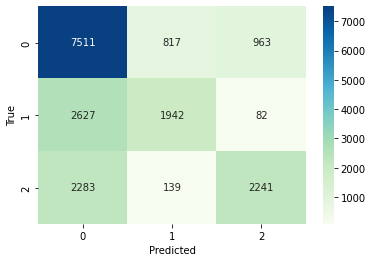

In [127]:
matrix = confusion_matrix(y_test_voting_arr, y_pred_voting)
sns.heatmap(matrix,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#### Exportación de Datos

Finalmente, exportamos el modelo utilizado:

In [128]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📒 Organización de Datos (75.06)/TPS/TP2/MODELOS/Voting_Classifier.joblib'
else:
  path = './MODELOS/Voting_Classifier.joblib'

dump(vot_clf, path)

['/content/drive/MyDrive/📒 Organización de Datos (75.06)/TPS/TP2/MODELOS/Voting_Classifier.joblib']

### 3. b) Stacking - Regresión
___

#### Preparación del dataset

Nuevamente, utilizamos los datasets de train y test previamente separados:

In [129]:
x_train_stacking = x_train_regresion
y_train_stacking = y_train_regresion

x_test_stacking = x_test_regresion
y_test_stacking = y_test_regresion

#### Definición del Ensamble


Lo que haremos en esta nueva sección, será implementar un nuevo tipo de ensable híbrido con la salvedad de que esta vez utilizaremos el tipo `cascading`.
El mismo se basa en el entrenamiento de distintos `modelos base`, y a su vez utilizará un `meta-modelo` el cual realizará su predicción en base a las predicciones de los diferentes modelos comentados anteriormente. 

Como es indicado por el enunciado del trabajo se utilizarán modelos de regresión. En particular, decidimos trabajar con:


*   KNN
*   XGBoost
*   AdaBoost



En esta línea, cargamos en memoria los modelos previamente guardados:

In [130]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📒 Organización de Datos (75.06)/TPS/TP1/MODELOS/KNN_Regressor_Train.joblib'
else:
  path = './MODELOS/KNN_Regressor_Train.joblib'

knn_rgs = load(path)

In [131]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📒 Organización de Datos (75.06)/TPS/TP1/MODELOS/XGB_Regressor_Train.joblib'
else:
  path = './MODELOS/XGB_Regressor_Train.joblib'

xgb_rgs = load(path)

[22:21:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [132]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📒 Organización de Datos (75.06)/TPS/TP1/MODELOS/AdaB_Regressor_Train.joblib'
else:
  path = './MODELOS/AdaB_Regressor_Train.joblib'

adb_rgs = load(path)

Recordemos que estos modelos fueron optimizados con los siguientes hiperparámetros:

- para **K Nearest Neighbors**: `{'weights': 'uniform', 'n_neighbors': 51, 'metric': 'chebyshev', 'leaf_size': 22, 'algorithm': 'ball_tree'}`
- para **Extreme Gradient Boosting**: `{'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.3}`
- para **Adaptive Boosting**: `{'n_estimators': 10, 'learning_rate': 1.02}`

Luego utilizamos los mismos para definir nuestro modelo base, en el cual luego se basará el meta-modelo.

In [133]:
base_models = [('KNN', knn_rgs),
               ('XGBoost', xgb_rgs),
               ('AdaBoost', adb_rgs)]

Como mencionamos, a continuación los utilizaremos para definir nuestro meta-modelo. Para este último, decidimos emplear el modelo de regresión logistica.

In [134]:
from sklearn.ensemble import GradientBoostingRegressor

meta_model = GradientBoostingRegressor()

Creamos nuestro ensamble indicando como modelos estimadores Knn, XGBoost y AdaBoost, y como estimador final el modelo de Regresión Lineal.

In [135]:
s = 5
n = 2

In [136]:
stacking_model = StackingRegressor(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=s,
                                    verbose=n)

#### Entrenamiento y Predicción

In [137]:
model_scores = defaultdict()

for name, model in base_models:
    print('Evaluating {}'.format(name))
    scores = evaluate_model(model, x_train_stacking, y_train_stacking, s, n)
    model_scores[name] = scores

Evaluating KNN


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed: 10.1min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating XGBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   59.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Evaluating AdaBoost


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   23.6s finished


Veamos cómo resultaron los scores de los modelos:

In [138]:
plot_results(model_scores, name='stacking_model_cv')

Entrenamos el modelo:

In [139]:
stacking_model.fit(x_train_stacking, y_train_stacking)

[22:33:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[22:40:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[22:40:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:41:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:41:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:41:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.5s finished


StackingRegressor(cv=5,
                  estimators=[('KNN',
                               KNeighborsRegressor(algorithm='ball_tree',
                                                   leaf_size=22,
                                                   metric='chebyshev',
                                                   n_neighbors=51)),
                              ('XGBoost',
                               XGBRegressor(colsample_bytree=0.3, gamma=0.1,
                                            learning_rate=0.3, max_depth=6,
                                            min_child_weight=5, missing=nan)),
                              ('AdaBoost',
                               AdaBoostRegressor(learning_rate=1.02,
                                                 n_estimators=10))],
                  final_estimator=GradientBoostingRegressor(), passthrough=True,
                  verbose=2)

Finalmente haremos la predicción:

In [140]:
y_pred_stacking = stacking_model.predict(x_test_stacking)

#### Métricas

Para poder evaluar la performance que obtuvo nuestro modelo utilizaremos la métrica de evaluación del error cuadrático medio (MSE) como se pide por enunciado.

In [141]:
mse = metrics.mean_squared_error(
        y_true  = y_test_stacking,
        y_pred  = y_pred_stacking,
        squared = True
       )

print(f"El error según la métrica 'Mean Square Error' de test es: {mse}")

El error según la métrica 'Mean Square Error' de test es: 106206251697.29155


#### Exportación de Datos

Finalmente, exportamos el modelo utilizado:

In [142]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📒 Organización de Datos (75.06)/TPS/TP2/MODELOS/Stacking_Regressor.joblib'
else:
  path = './MODELOS/Stacking_Regressor.joblib'

dump(stacking_model, path)

['/content/drive/MyDrive/📒 Organización de Datos (75.06)/TPS/TP2/MODELOS/Stacking_Regressor.joblib']

## Conclusiones

A modo de finalización de este trabajo, haremos un pequeño repaso sobre todos los puntos que analizamos y sus respectivos resultados y/o observaciones hechos por nosotros:

Sobre el análisis realizado en el apartado de **procesamiento del lenguaje natural**, y en particular haciendo referencia a las métricas que obtuvimos luego del entrenamiento y predicción con el dataset producto de la ampliación, utilizando el modelo XGBoost, pudimos observar que si bien aún las métricas no nos resultan del todo satisfactorias cumplen con el objetivo de mejorar las resultantes del trabajo anterior. Más allá de que la cantidad de aciertos continúa sin incrementar, tanto el error MSE como el RMSE decrecieron ofreciendo mejores resultados. Por otro lado, el coeficiente de determinación se incrementó notoriamente llegando casi a un 0.9%. 

En cuanto a lo referido sobre **redes neuronales**, la comparación será directamente en base a los nuevos modelos ya que el dataset utilizado es compartido en ambos trabajos. Dicho esto, el error cometido en el modelo de regresión es significativamente pequeño. Teniendo en cuenta los resultantes del TP1, si utilizamos el menor luego de que éstos tuvieron su optimización de parámetros correspondiente, notamos que el que mejor performa es XGBoost con un MSE de 51650994876 (al cual de todas formas le atribuímos arrastre de error en nuestro planteo). Utilizando redes neuronales cometemos tan solo un error cuadrático medio equivalente a 1.36. Por otro lado, en lo que respecta al modelo de clasificación, obtuvimos resultados bastante similares. Si bien tanto el accuracy, precisión y F1-Score dieron distintos, la diferencia es de tan solo uno/dos puntos. Con esto concluimos que para clasificación no se notan mejoras por sobre los modelos utilizados en el trabajo anterior.

Como último requerimiento se pidió estudiar las métricas tanto para regresión como clasificación pero haciendo uso de **ensambles**, en particular de tipo híbridos. En lo que respecta al utilizado para clasificación (Voting) obtuvimos mejores resultados para las métricas de Accuracy, Recall y F1-Score. Sin embargo, aunque en Precisión disminuyó un poco, esta diferencia continúa siendo no significativa. Pasando al ensamble de regresión (Stacking) el MSE resultante que obtuvimos fue 238481755830. Creemos que nuevamente estamos cometiendo involuntariamente algún arrastre de error en alguno de los incisos desarrollados, ya que este error es incluso mayor a los cometidos en los modelos individuales desarrollados en el TP1, y no estaría respetando la regla principal de ‘*La sabiduría de las multitudes*’.